In [7]:
from emir import (GANDeficiencyArgs,GANDeficiencyEstimator, GANTrickedDeficiencyEstimator, WassersteinDeficiencyEstimator, WassersteinGPDeficiencyEstimator)
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.datasets import make_blobs

from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

# create logger
import logging
logging.basicConfig(level=logging.INFO)


In [8]:

X = make_blobs(n_samples=10000, n_features=16, centers=6, cluster_std=5.0, center_box=(-50, 50), shuffle=True, random_state=None)


Text(0.5, 1.0, 'Sparse Random projection')

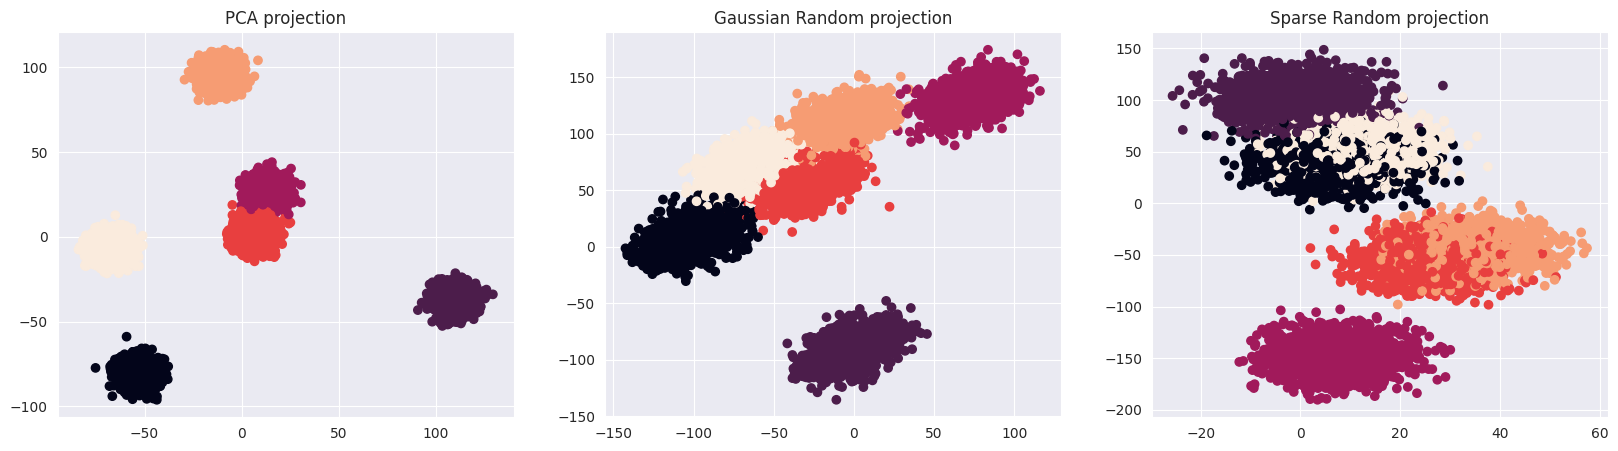

In [11]:
# Make a PCA projection 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[0])

# Make a random projection
grp = GaussianRandomProjection(n_components=2, )
X_grp = grp.fit_transform(X[0])

sparse_rp = SparseRandomProjection(n_components=2, )
X_srp = sparse_rp.fit_transform(X[0])


fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].scatter(X_pca[:,0], X_pca[:,1], c=X[1])
ax[0].set_title("PCA projection")

ax[1].scatter(X_grp[:,0], X_grp[:,1], c=X[1])
ax[1].set_title("Gaussian Random projection")

ax[2].scatter(X_srp[:,0], X_srp[:,1], c=X[1])
ax[2].set_title("Sparse Random projection")



In [13]:

U = torch.tensor(X_pca, dtype=torch.float32)
Z = torch.tensor(X_srp, dtype=torch.float32)



In [30]:
def evaluate_deficiency(U, Z):

    args = GANDeficiencyArgs(device='cpu',
                             disc_clip=0.01,
                             gen_hidden_dim=16,
                             gen_n_layers=5,
                             critic_n_layers=3,
                             critic_hidden_dim=8,
                             critic_repeats=5,
                             gan_n_epochs=100,
                             gen_lr=2e-4,
                             critic_lr=2e-4,
                             gan_batch_size=64,
                             )
    estimator = WassersteinGPDeficiencyEstimator(args, x_dim=2, y_dim=2)


    results = []

    for _ in range(1):
        estimator.fit_estimator(U, Z)
        Zchap = estimator.gen(U)
        results.append(Zchap.detach().numpy())
        
    deficiency = estimator.batch_eval(U, Z).item()
        
    return estimator, results, deficiency
    

In [31]:
easy_direction = evaluate_deficiency(U, Z)
hard_direction = evaluate_deficiency(Z, U)



INFO:emir.estimators.deficiency_estimator:Epoch 1/100, Critic loss: -47.04283905029297, Generator loss: -83.70348358154297
INFO:emir.estimators.deficiency_estimator:Epoch 2/100, Critic loss: -50.31557083129883, Generator loss: -52.8830451965332
INFO:emir.estimators.deficiency_estimator:Epoch 3/100, Critic loss: -259.673095703125, Generator loss: 53.29170227050781
INFO:emir.estimators.deficiency_estimator:Epoch 4/100, Critic loss: -81.17195892333984, Generator loss: 1.3962148427963257
INFO:emir.estimators.deficiency_estimator:Epoch 5/100, Critic loss: -120.18864440917969, Generator loss: -3.648749589920044
INFO:emir.estimators.deficiency_estimator:Epoch 6/100, Critic loss: -135.43751525878906, Generator loss: -6.163305759429932
INFO:emir.estimators.deficiency_estimator:Epoch 7/100, Critic loss: -125.12449645996094, Generator loss: -3.7127277851104736
INFO:emir.estimators.deficiency_estimator:Epoch 8/100, Critic loss: -78.09537506103516, Generator loss: 23.095504760742188
INFO:emir.estim

1


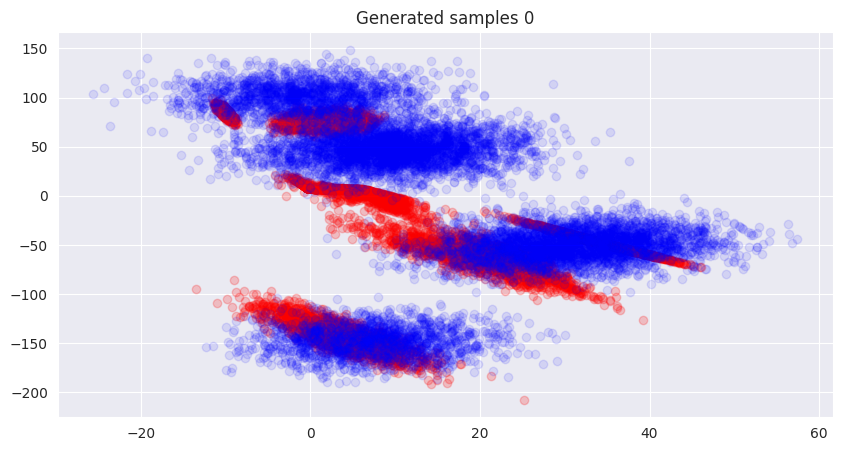

In [37]:
results = easy_direction[1]
print(len(results))
fig, ax = plt.subplots(1,len(results), figsize=(10,5), squeeze=False)

for k, Zchap in enumerate(results):
    ax[0, k].scatter(Zchap[:,0], Zchap[:,1], c="red", alpha= 0.2)
    ax[0, k].scatter(Z[:,0], Z[:,1], c="blue", alpha=0.1)
    ax[0, k].set_title(f"Generated samples {k}")

1


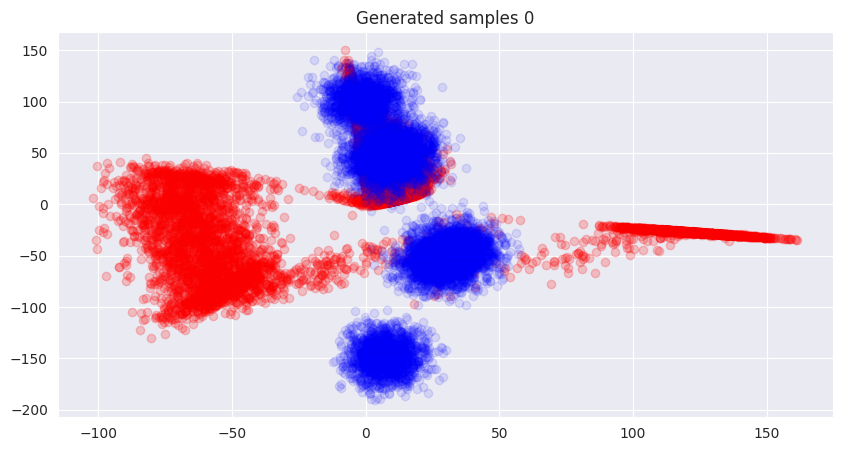

In [38]:

results = hard_direction[1]
print(len(results))
fig, ax = plt.subplots(1,len(results), figsize=(10,5), squeeze=False)

for k, Zchap in enumerate(results):
    ax[0, k].scatter(Zchap[:,0], Zchap[:,1], c="red", alpha= 0.2)
    ax[0, k].scatter(Z[:,0], Z[:,1], c="blue", alpha=0.1)
    ax[0, k].set_title(f"Generated samples {k}")


In [40]:
easy_deficiency = easy_direction[0].batch_eval(U, Z)
hard_deficiency = hard_direction[0].batch_eval(Z, U)

# Easy should be lower than hard
print(easy_deficiency, hard_deficiency)

tensor(61.5408, grad_fn=<MeanBackward0>) tensor(92.6436, grad_fn=<MeanBackward0>)
